# 5章 誤差逆伝播法

## 5.4 単純なレイヤの実装

### 5.4.1 乗算レイヤの実装

In [6]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [7]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


5.4.2 加算レイヤの実装

In [8]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [10]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 5.5 活性化関数レイヤの実装

### 5.5.1 ReLU レイヤ

$$
y=\left\{
\begin{array}{ll}
x & (x>0) \\
0 & (x\leqq0) \\
\end{array}
\right.
$$

$$
\frac{\partial y}{\partial x}=\left\{
\begin{array}{ll}
1 & (x>0) \\
0 & (x\leqq0) \\
\end{array}
\right.
$$

In [2]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
        
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

### 5.5.2 Sigmoid レイヤ

$$
y=\frac{1}{1+exp(-x)}
$$

$$
\frac{\partial y}{\partial x}=y^{2}exp(-x)=y(1-y)
$$

In [5]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out)
        
        return dx

## 5.6 Affine / Softmax レイヤの実装

### 5.6.1 Affine レイヤ

$$
\frac{\partial L}{\partial \bf Y} =
( \frac{\partial L}{\partial y_{1}},\frac{\partial L}{\partial y_{2}},\frac{\partial L}{\partial y_{3}})
$$

$$
{\bf W} =
\begin{pmatrix}
w_{11} &w_{21} &w_{31}\\
w_{12} &w_{22} &w_{32}
\end{pmatrix}\\
$$

$$
{\bf X} = ( x_{0},x_{1} )
$$

$$
\frac{\partial L}{\partial \bf X} =
    ( \frac{\partial L}{\partial x_{1}},\frac{\partial L}{\partial x_{2}})\\=( \frac{\partial L}{\partial y_{1}}w_{11}+\frac{\partial L}{\partial y_{2}}w_{21}+\frac{\partial L}{\partial y_{3}}w_{31}, \frac{\partial L}{\partial y_{1}}w_{12}+\frac{\partial L}{\partial y_{2}}w_{22}+\frac{\partial L}{\partial y_{3}}w_{32} )\\=\frac{\partial L}{\partial \bf Y} \cdot {\bf W^{T}}
$$

$$
\frac{\partial L}{\partial \bf X}=\frac{\partial L}{\partial \bf Y}\cdot {\bf W}^{T} \\
\frac{\partial L}{\partial \bf W}={\bf X}^{T}\cdot \frac{\partial L}{\partial \bf Y}
$$

### 5.6.2 バッチ版 Affine レイヤ

In [7]:
class Affine:
    def __init__(self, W ,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

### 5.6.3 Softmax-with-Loss レイヤ

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 誤差逆伝播法の実装

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの 実装

In [13]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, 
                 weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
            
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 5.7.3 誤差逆伝播法の勾配確認

In [15]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
    
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:2.01085902782e-13
b1:9.17005403361e-13
W2:7.9879719633e-13
b2:1.2012613404e-10


### 5.7.4 誤差逆伝播法を使った学習

In [19]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
    
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        print("Iteration : {0}".format(i))
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

Iteration : 0
0.147083333333 0.1486
Iteration : 600
0.903333333333 0.9084
Iteration : 1200
0.920816666667 0.9245
Iteration : 1800
0.929683333333 0.9297
Iteration : 2400
0.94365 0.9412
Iteration : 3000
0.95055 0.9469
Iteration : 3600
0.957383333333 0.9534
Iteration : 4200
0.95935 0.9556
Iteration : 4800
0.9643 0.9589
Iteration : 5400
0.968116666667 0.9622
Iteration : 6000
0.970333333333 0.964
Iteration : 6600
0.9705 0.9635
Iteration : 7200
0.9736 0.9658
Iteration : 7800
0.974216666667 0.9654
Iteration : 8400
0.97555 0.9675
Iteration : 9000
0.975883333333 0.9673
Iteration : 9600
0.979216666667 0.9701


In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


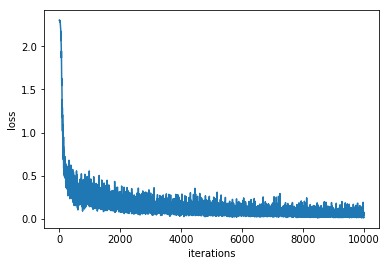

In [25]:
plt.plot(train_loss_list)
plt.xlabel("iterations")
plt.ylabel("loss")

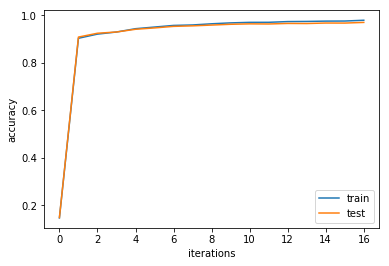

In [27]:
plt.plot(train_acc_list, label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()